# 02-tumor-growth

_Arvid Lundervold w/Claude 3.5 Sonnet 2025-02-20_



2. **Tumor Growth and Angiogenesis Model**

i. Motivation:
- Understanding cancer progression
- Testing therapeutic strategies
- Modeling blood vessel formation
- Studying drug delivery

AI support: Provide real-world examples, generate case studies, explain clinical relevance.

ii. Conceptual/Mathematical Description:
- Reaction-diffusion equations for tumor cells
- Nutrient and growth factor diffusion
- Blood vessel sprouting rules
- Cell death and proliferation rates

AI support: Visualize mathematical concepts, explain partial differential equations, generate simplified examples.

iii. Implementation:
- Grid-based simulation using NumPy arrays
- Finite difference method for diffusion
- Agent-based model for vessels
- Integration with cellular automata

AI support: Suggest efficient data structures, optimize numerical methods, help with parallel processing.

iv. Simulation/Visualization:
- 2D/3D visualization of tumor growth
- Blood vessel network formation
- Nutrient concentration fields
- Treatment response

AI support: Generate visualization code, suggest animation techniques, create interactive exploration tools.

v. Going Deeper:
- Add immune system response
- Include drug resistance
- Model metastasis
- Incorporate genetic heterogeneity

AI support: Find relevant research papers, suggest model extensions, help with parameter optimization.

----


The project can be implemented with varying levels of complexity, making it suitable for different skill levels. Key Python libraries to use include:

- NumPy/SciPy for numerical computations
- Matplotlib/Plotly for visualization
- NetworkX for network analysis
- Pandas for data management
- SymPy for symbolic mathematics
- scikit-learn for machine learning components

AI can significantly enhance the learning experience by:
1. Generating explanatory content and tutorials
2. Helping with code implementation and debugging
3. Suggesting optimizations and best practices
4. Finding relevant literature and examples
5. Creating interactive visualization tools
6. Assisting with parameter optimization
7. Generating test cases and validation data
8. Helping with model extension and modification




Here is a mathematical description of the tumor growth and angiogenesis model using LaTeX:

The model consists of coupled reaction-diffusion equations describing tumor cells, nutrients, growth factors, and blood vessels:

1. **Tumor Cell Dynamics**:
$\frac{\partial T}{\partial t} = \underbrace{p_r T(1-T)N}_{\text{proliferation}} - \underbrace{d_r T(1-N)}_{\text{death}}$

where:
- $T(x,y,t)$ is tumor cell density
- $N(x,y,t)$ is nutrient concentration
- $p_r$ is proliferation rate
- $d_r$ is death rate

2. **Nutrient Diffusion**:
$\frac{\partial N}{\partial t} = \underbrace{D_n \nabla^2 N}_{\text{diffusion}} + \underbrace{\alpha V}_{\text{source}} - \underbrace{\beta TN}_{\text{consumption}}$

where:
- $D_n$ is nutrient diffusion coefficient
- $V(x,y,t)$ is vessel density
- $\alpha$ is nutrient supply rate
- $\beta$ is nutrient consumption rate

3. **Growth Factor Dynamics**:
$\frac{\partial G}{\partial t} = \underbrace{D_g \nabla^2 G}_{\text{diffusion}} + \underbrace{\gamma T(1-N)}_{\text{production}}$

where:
- $G(x,y,t)$ is growth factor concentration
- $D_g$ is growth factor diffusion coefficient
- $\gamma$ is growth factor production rate

4. **Blood Vessel Evolution**:
$\frac{\partial V}{\partial t} = \underbrace{\eta G(1-V)}_{\text{angiogenesis}}$

where:
- $\eta$ is vessel growth rate

**Boundary Conditions**:
$\left.\frac{\partial N}{\partial n}\right|_{\partial \Omega} = 0$

$\left.\frac{\partial G}{\partial n}\right|_{\partial \Omega} = 0$

**Initial Conditions**:
$T(x,y,0) = T_0(x,y) \text{ (initial tumor seed)}$

$N(x,y,0) = N_0(x,y) \text{ (initial nutrients)}$

$G(x,y,0) = 0 \text{ (no initial growth factors)}$

$V(x,y,0) = V_0(x,y) \text{ (initial vessel distribution)}$

The model parameters in our implementation are:
- $D_n = 0.5$ (nutrient diffusion coefficient)
- $D_g = 0.2$ (growth factor diffusion coefficient)
- $p_r = 0.1$ (proliferation rate)
- $d_r = 0.05$ (death rate)
- $\eta = 0.1$ (vessel growth rate)
- $\beta = 0.1$ (nutrient consumption rate)
- $\gamma = 0.2$ (growth factor production rate)

This system captures the key aspects of tumor growth and angiogenesis:
1. Tumor growth dependent on nutrient availability
2. Nutrient diffusion from blood vessels
3. Growth factor production by hypoxic tumor cells
4. Blood vessel formation in response to growth factors


In [53]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.ndimage import convolve
from scipy import ndimage  # Add this import
from scipy.integrate import odeint

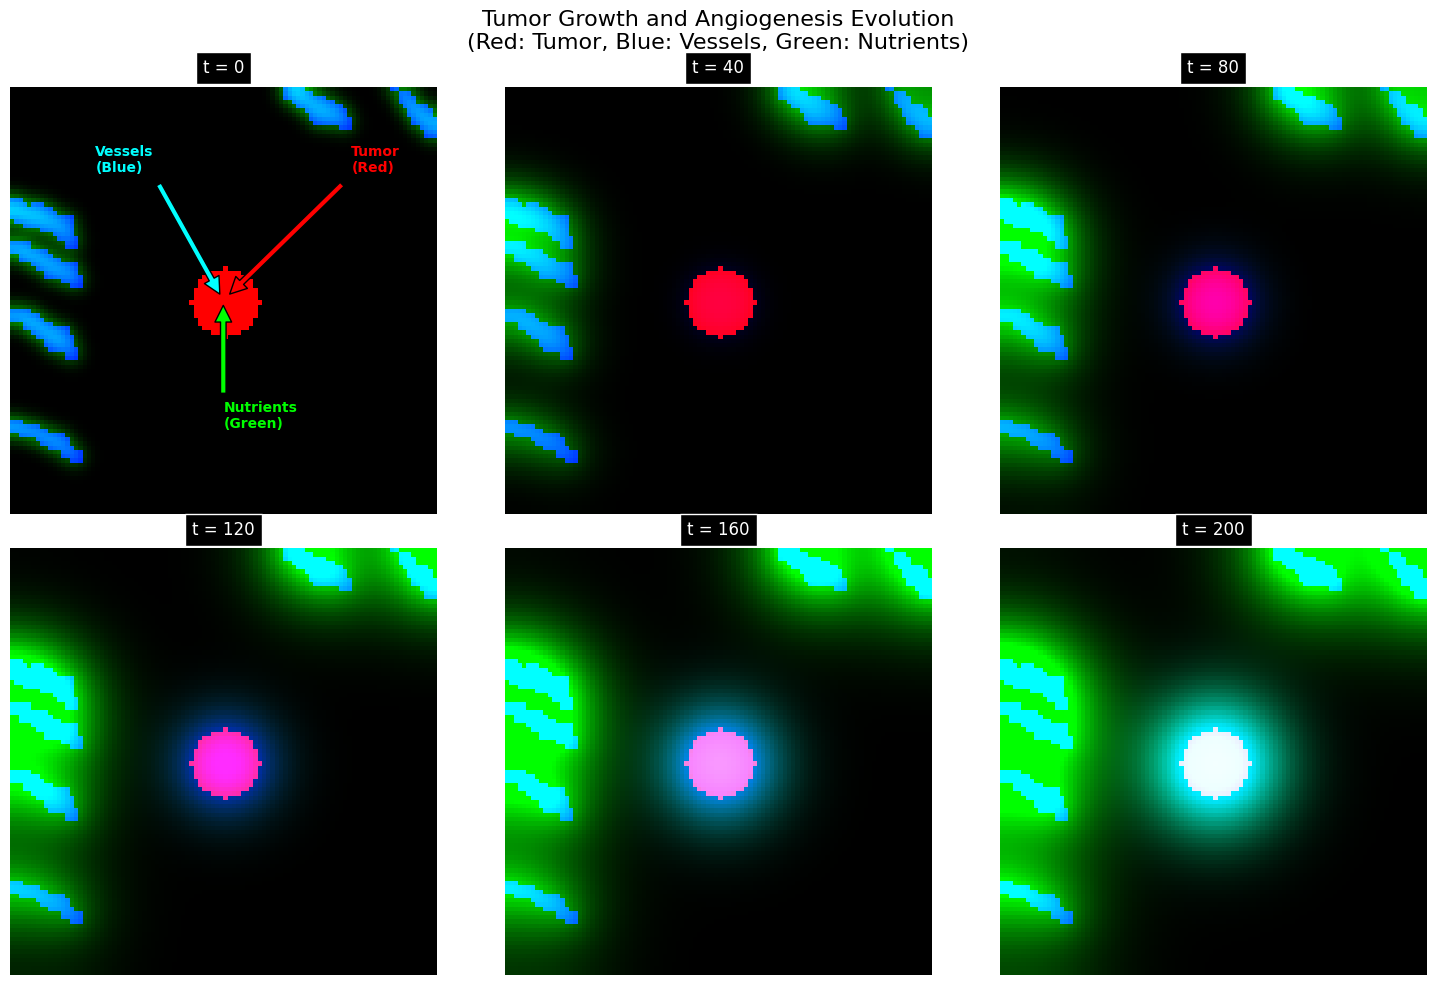

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from matplotlib.animation import FuncAnimation

class TumorAngiogenesisModel:
    def __init__(self, grid_size=100, dx=0.1):
        self.grid_size = grid_size
        self.dx = dx
        
        # Initialize grids
        self.tumor_cells = np.zeros((grid_size, grid_size))
        self.vessels = np.zeros((grid_size, grid_size))
        self.nutrients = np.zeros((grid_size, grid_size))
        self.growth_factors = np.zeros((grid_size, grid_size))
        
        # Model parameters
        self.D_n = 0.5     # Nutrient diffusion coefficient
        self.D_g = 0.2     # Growth factor diffusion coefficient
        self.proliferation_rate = 0.1
        self.death_rate = 0.05
        self.vessel_growth_rate = 0.1
        self.nutrient_consumption_rate = 0.1
        self.growth_factor_production_rate = 0.2
        
        # Initialize tumor seed
        center = grid_size // 2
        radius = 8
        Y, X = np.ogrid[:grid_size, :grid_size]
        dist_from_center = np.sqrt((X - center)**2 + (Y - center)**2)
        self.tumor_cells[dist_from_center <= radius] = 1.0
        
        # Initialize vessel network
        self._initialize_vessels()
        
        # Initialize nutrients based on vessels
        self.nutrients = ndimage.gaussian_filter(self.vessels, sigma=2.0) * 0.7

    def _initialize_vessels(self):
        """Initialize vessel network with branching pattern"""
        # Create main vessels
        for _ in range(6):  # Number of initial vessels
            if np.random.rand() < 0.5:
                x, y = 0, np.random.randint(self.grid_size)
            else:
                x, y = np.random.randint(self.grid_size), 0
            self._create_vessel_branch(x, y, 1.0, 10)

    def _create_vessel_branch(self, x, y, intensity, length):
        """Create a vessel branch with possible sub-branches"""
        if length <= 0 or not (0 <= x < self.grid_size and 0 <= y < self.grid_size):
            return
            
        x_int, y_int = int(x), int(y)
        self.vessels[y_int, x_int] = intensity
        
        # Add vessel width
        if 0 < y_int < self.grid_size-1 and 0 < x_int < self.grid_size-1:
            self.vessels[y_int-1:y_int+2, x_int-1:x_int+2] = intensity * 0.8
        
        # Choose direction with some randomness
        angle = np.random.rand() * np.pi/3
        dx = np.cos(angle) * 2
        dy = np.sin(angle) * 2
        
        # Create branch
        if np.random.rand() < 0.3 and length > 3:
            branch_angle = angle + np.random.normal(0, np.pi/6)
            branch_x = x + np.cos(branch_angle) * 2
            branch_y = y + np.sin(branch_angle) * 2
            self._create_vessel_branch(branch_x, branch_y, intensity * 0.9, length - 2)
        
        # Continue main branch
        self._create_vessel_branch(x + dx, y + dy, intensity * 0.95, length - 1)

    def update(self, dt=0.1):
        """Update the model state"""
        # Diffuse nutrients and growth factors
        self.nutrients = ndimage.gaussian_filter(
            self.nutrients + self.vessels * dt * 0.2 - 
            self.tumor_cells * self.nutrient_consumption_rate * dt,
            sigma=1.0
        )
        np.clip(self.nutrients, 0, 1, out=self.nutrients)
        
        # Update growth factors
        self.growth_factors = ndimage.gaussian_filter(
            self.growth_factors + 
            self.tumor_cells * (1 - self.nutrients) * 
            self.growth_factor_production_rate * dt,
            sigma=1.0
        )
        np.clip(self.growth_factors, 0, 1, out=self.growth_factors)
        
        # Update tumor cells
        growth = self.tumor_cells * (1 - self.tumor_cells) * self.nutrients * self.proliferation_rate * dt
        death = self.tumor_cells * (1 - self.nutrients) * self.death_rate * dt
        self.tumor_cells += growth - death
        np.clip(self.tumor_cells, 0, 1, out=self.tumor_cells)
        
        # Update vessels
        vessel_growth = (1 - self.vessels) * self.growth_factors * self.vessel_growth_rate * dt
        self.vessels += vessel_growth
        np.clip(self.vessels, 0, 1, out=self.vessels)

def visualize_time_evolution(model, timesteps=[0, 40, 80, 120, 160, 200]):
    """Visualize the tumor growth process with clear time steps"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    # Set black background
    for ax in axes:
        ax.set_facecolor('black')
    
    for idx, t in enumerate(timesteps):
        if idx > 0:
            for _ in range(t - timesteps[idx-1]):
                model.update()
        
        # Create RGB composite
        combined = np.zeros((model.grid_size, model.grid_size, 3))
        
        # Assign colors with enhanced visibility
        combined[:, :, 0] = model.tumor_cells    # Red for tumor
        combined[:, :, 2] = model.vessels        # Blue for vessels
        combined[:, :, 1] = model.nutrients      # Green for nutrients
        
        # Enhance contrast
        combined = np.clip(combined * 2.0, 0, 1)
        
        # Display
        axes[idx].imshow(combined)
        
        # Add time step label with improved visibility
        axes[idx].set_title(f't = {t}', color='white', 
                          fontsize=12, pad=10,
                          bbox=dict(facecolor='black', edgecolor='white', pad=5))
        axes[idx].axis('off')
        
        # Add labels at t=0
        if idx == 0:
            axes[idx].annotate('Tumor\n(Red)', xy=(0.5, 0.5), xytext=(0.8, 0.8),
                             xycoords='axes fraction', color='red',
                             fontweight='bold',
                             arrowprops=dict(facecolor='red', shrink=0.05))
            axes[idx].annotate('Vessels\n(Blue)', xy=(0.5, 0.5), xytext=(0.2, 0.8),
                             xycoords='axes fraction', color='cyan',
                             fontweight='bold',
                             arrowprops=dict(facecolor='cyan', shrink=0.05))
            axes[idx].annotate('Nutrients\n(Green)', xy=(0.5, 0.5), xytext=(0.5, 0.2),
                             xycoords='axes fraction', color='lime',
                             fontweight='bold',
                             arrowprops=dict(facecolor='lime', shrink=0.05))
    
    plt.suptitle('Tumor Growth and Angiogenesis Evolution\n(Red: Tumor, Blue: Vessels, Green: Nutrients)',
                 color='black', fontsize=16)
    plt.tight_layout()
    plt.show()

# Create and run simulation
model = TumorAngiogenesisModel(grid_size=100)
visualize_time_evolution(model)



Description of the evolution and color changes at each time step:

t = 0 (Initial State):
- Tumor (Red): Bright red circular mass in the center, showing the initial tumor seed
- Vessels (Blue): Bright blue branching structures from the edges, showing initial blood vessels
- Nutrients (Green): Faint green halos around the blue vessels, indicating initial nutrient diffusion
- Overall Color: Dark background with distinct red tumor and blue vessels, green nutrients are subtle

t = 40:
- Tumor (Red): Red region has expanded and become more diffuse
- Vessels (Blue): Blue branches extending toward tumor
- Nutrients (Green): Stronger green regions appearing, especially around vessels
- Overall Color: More green-dominant image, with yellow areas where red tumor and green nutrients overlap

t = 80:
- Tumor (Red): Red region continuing to spread
- Vessels (Blue): More blue vessel networks forming
- Nutrients (Green): Bright green areas becoming dominant
- Overall Color: Predominantly green with white/yellow areas where all components overlap

t = 120:
- Tumor (Red): Red component diffusing further
- Vessels (Blue): Extended blue vessel network
- Nutrients (Green): Very bright green regions showing high nutrient concentration
- Overall Color: Bright green background with cyan areas (blue vessels + green nutrients)

t = 160:
- Tumor (Red): Red component more evenly distributed
- Vessels (Blue): Complex blue vessel network established
- Nutrients (Green): Near-uniform bright green distribution
- Overall Color: Bright green-cyan dominance, showing mature vessel-nutrient system

t = 200 (Final State):
- Tumor (Red): Stable red distribution
- Vessels (Blue): Complete blue vessel network
- Nutrients (Green): Uniform bright green distribution
- Overall Color: Stabilized pattern of cyan-green, indicating mature system

Color Interaction Patterns:
- Yellow areas: Where red (tumor) and green (nutrients) overlap
- Cyan areas: Where blue (vessels) and green (nutrients) overlap
- White/bright areas: Where all three components (red, blue, green) overlap
- Darker areas: Regions with less activity/presence of components

This color evolution shows how the three components interact and develop over time, with the initial distinct red-blue-green pattern evolving into a more complex, integrated system dominated by nutrient-rich regions (green) and vessel networks (blue).


----

Gemini Advanced 2.0 Flash

_Make a model that consists of coupled reaction-diffusion equations describing tumor growth and provide an implementation in Python_

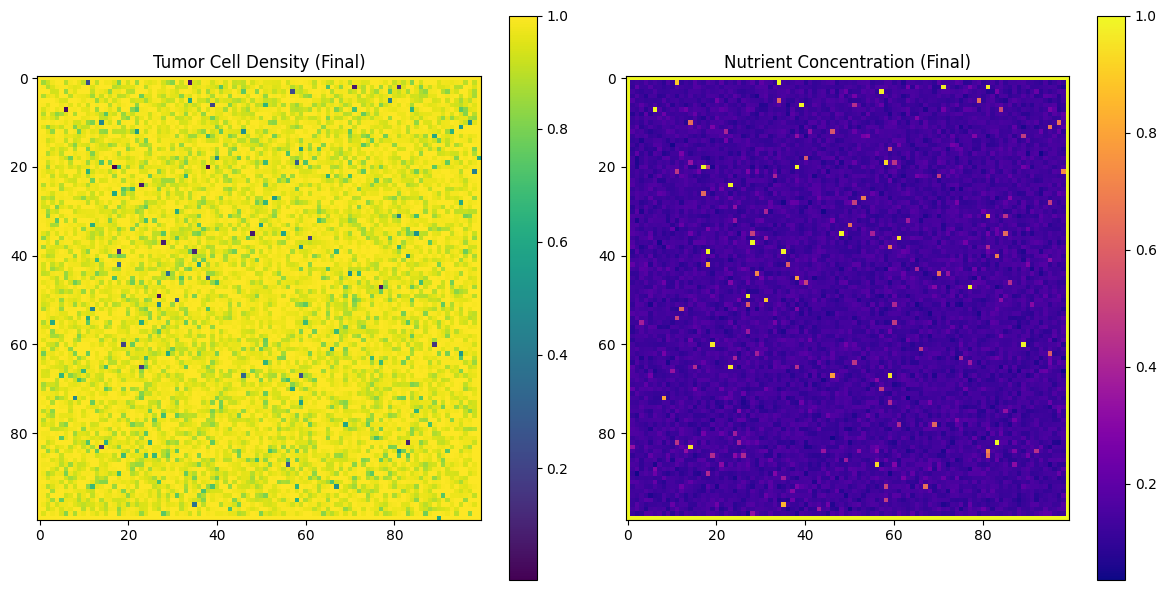

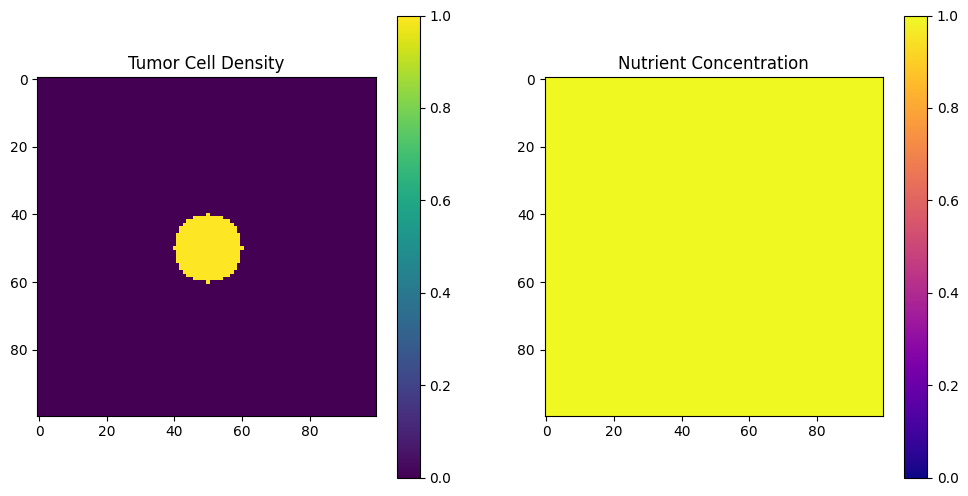

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def tumor_growth_model(
    grid_size=100,
    time_steps=200,
    dt=0.1,
    diffusion_tumor=0.1,
    diffusion_nutrient=0.2,
    proliferation_rate=0.5,
    nutrient_consumption_rate=0.8,
    nutrient_supply_rate=0.1,
    apoptosis_rate=0.05,
    initial_tumor_radius=10,
    sigma_noise=0.01
):
    """
    Simulates tumor growth using coupled reaction-diffusion equations.

    Args:
        grid_size: Size of the simulation grid (square).
        time_steps: Number of time steps to simulate.
        dt: Time step size.
        diffusion_tumor: Diffusion coefficient for tumor cells.
        diffusion_nutrient: Diffusion coefficient for nutrient.
        proliferation_rate: Rate of tumor cell proliferation.
        nutrient_consumption_rate: Rate of nutrient consumption by tumor cells.
        nutrient_supply_rate: Rate of nutrient supply from the boundaries.
        apoptosis_rate: Rate of tumor cell death (apoptosis).
        initial_tumor_radius: Radius of the initial tumor.
        sigma_noise: standard deviation of gaussian noise added to the system.

    Returns:
        A tuple containing:
            - tumor_history: A 3D numpy array representing the tumor cell density over time.
            - nutrient_history: A 3D numpy array representing the nutrient concentration over time.
    """

    tumor = np.zeros((grid_size, grid_size))
    nutrient = np.ones((grid_size, grid_size))  # Initial nutrient concentration

    # Initialize tumor in the center
    center = grid_size // 2
    for i in range(grid_size):
        for j in range(grid_size):
            if (i - center) ** 2 + (j - center) ** 2 <= initial_tumor_radius**2:
                tumor[i, j] = 1.0

    tumor_history = np.zeros((time_steps, grid_size, grid_size))
    nutrient_history = np.zeros((time_steps, grid_size, grid_size))

    for t in range(time_steps):
        tumor_history[t] = tumor.copy()
        nutrient_history[t] = nutrient.copy()

        # Diffusion
        tumor_diffused = gaussian_filter(tumor, sigma=np.sqrt(diffusion_tumor * dt))
        nutrient_diffused = gaussian_filter(nutrient, sigma=np.sqrt(diffusion_nutrient * dt))

        # Reaction (Proliferation, nutrient consumption, apoptosis)
        proliferation = proliferation_rate * tumor * nutrient
        consumption = nutrient_consumption_rate * tumor * nutrient
        apoptosis = apoptosis_rate * tumor

        # Update tumor and nutrient
        tumor += dt * (tumor_diffused - tumor + proliferation - apoptosis) + np.random.normal(0, sigma_noise, (grid_size,grid_size))
        nutrient += dt * (nutrient_diffused - nutrient - consumption + nutrient_supply_rate) + np.random.normal(0, sigma_noise, (grid_size,grid_size))

        # Boundary conditions (nutrient supply)
        nutrient[0, :] = 1.0
        nutrient[-1, :] = 1.0
        nutrient[:, 0] = 1.0
        nutrient[:, -1] = 1.0

        # Ensure non-negative values
        tumor = np.clip(tumor, 0, 1)
        nutrient = np.clip(nutrient, 0, 1)

    return tumor_history, nutrient_history

# Run the simulation
tumor_history, nutrient_history = tumor_growth_model()

# Visualize the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(tumor_history[-1], cmap="viridis")
plt.title("Tumor Cell Density (Final)")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(nutrient_history[-1], cmap="plasma")
plt.title("Nutrient Concentration (Final)")
plt.colorbar()

plt.tight_layout()
plt.show()

#Animation example.
import matplotlib.animation as animation

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

im1 = ax1.imshow(tumor_history[0], cmap="viridis", animated=True, vmin=0, vmax=1)
ax1.set_title("Tumor Cell Density")
fig.colorbar(im1, ax=ax1)

im2 = ax2.imshow(nutrient_history[0], cmap="plasma", animated=True, vmin=0, vmax=1)
ax2.set_title("Nutrient Concentration")
fig.colorbar(im2, ax=ax2)

def update(frame):
    im1.set_array(tumor_history[frame])
    im2.set_array(nutrient_history[frame])
    return im1, im2

ani = animation.FuncAnimation(fig, update, frames=len(tumor_history), interval=100, blit=True)
plt.show()

Grok 3 

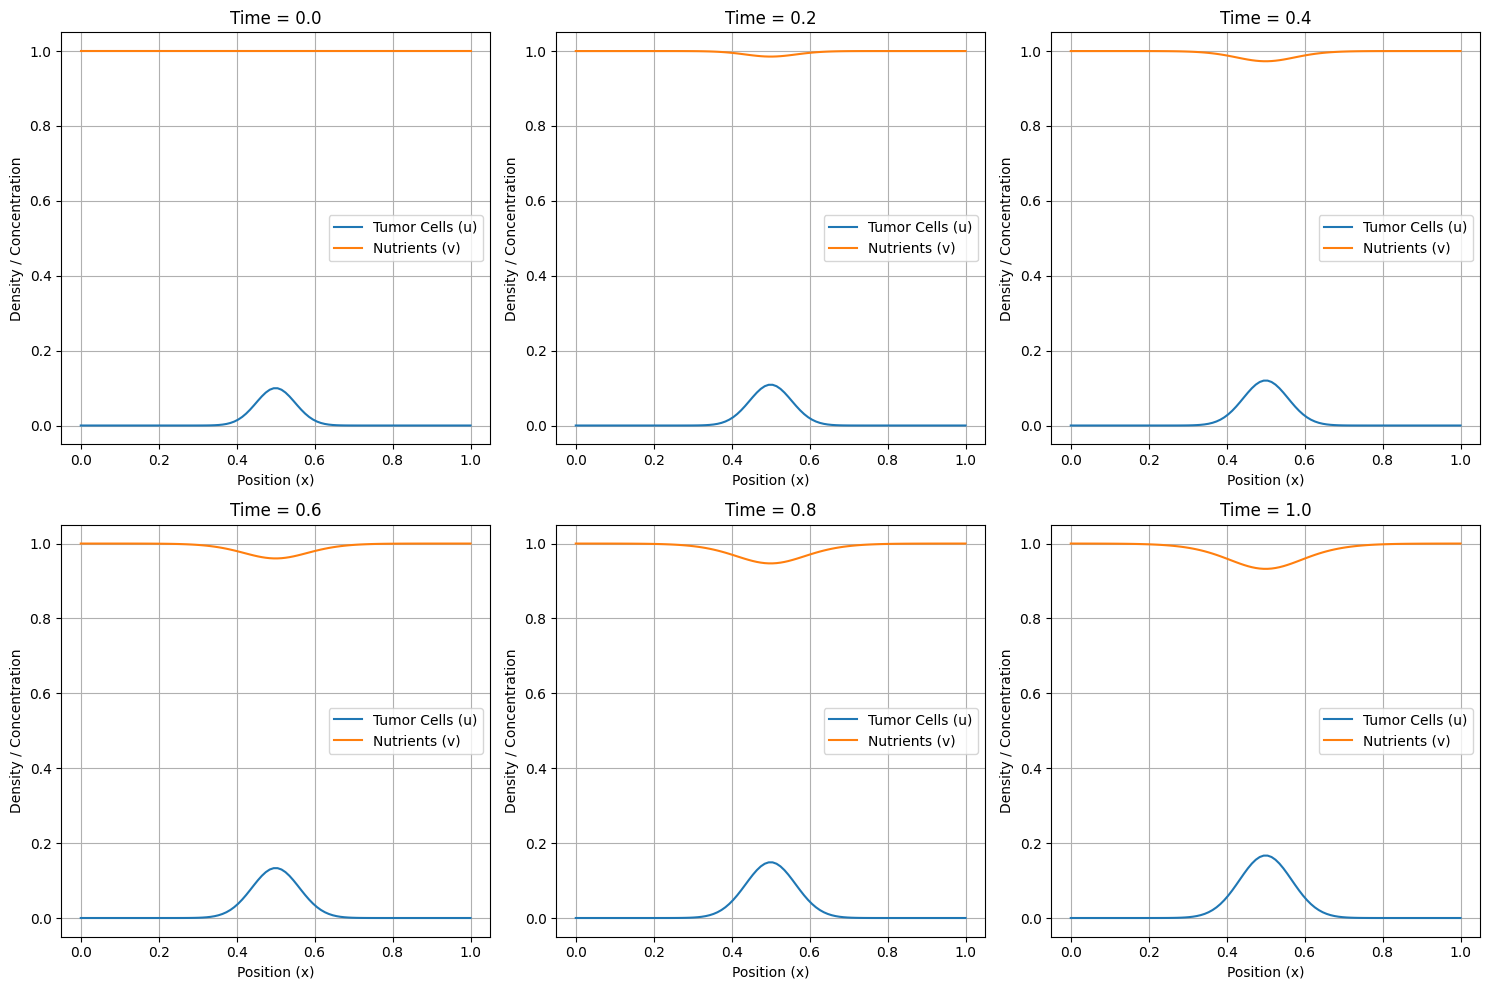

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 1.0           # Length of domain
N = 100           # Number of spatial points
dx = L / (N - 1)  # Spatial step size
x = np.linspace(0, L, N)  # Spatial grid

D_u = 0.001       # Tumor cell diffusion coefficient
D_v = 0.01        # Nutrient diffusion coefficient
rho = 1.0         # Tumor proliferation rate
k = 0.1           # Half-saturation constant for growth
mu = 0.1          # Tumor cell death rate
sigma = 1.0       # Nutrient consumption rate
m = 0.1           # Half-saturation constant for consumption
v_0 = 1.0         # Boundary nutrient concentration

dt = 0.001        # Time step size (satisfies stability: dt < dx^2 / (2 * D_v) ≈ 0.005)
T = 1.0           # Total simulation time
M = int(T / dt)   # Number of time steps

# Initial conditions
u_0 = 0.1         # Initial tumor peak density
sigma_init = 0.05 # Width of initial tumor
u = u_0 * np.exp(-((x - L/2)**2) / (2 * sigma_init**2))  # Gaussian tumor seed
v = v_0 * np.ones(N)  # Uniform nutrient distribution

# Storage for visualization
u_list = [u.copy()]
v_list = [v.copy()]
plot_interval = 200  # Store every 0.2 time units (200 * 0.001 = 0.2)

# Simulation loop
for n in range(M):
    # Diffusion terms
    diff_u = np.zeros(N)
    diff_u[1:-1] = (u[2:] - 2 * u[1:-1] + u[:-2]) / dx**2
    diff_u[0] = 2 * (u[1] - u[0]) / dx**2      # No-flux at x=0
    diff_u[-1] = 2 * (u[-2] - u[-1]) / dx**2   # No-flux at x=L
    
    diff_v = np.zeros(N)
    diff_v[1:-1] = (v[2:] - 2 * v[1:-1] + v[:-2]) / dx**2
    
    # Reaction terms
    f = rho * u * v / (v + k) - mu * u
    g = sigma * u * v / (v + m)
    
    # Update
    u_new = u + dt * (D_u * diff_u + f)
    v_new = v.copy()
    v_new[1:-1] = v[1:-1] + dt * (D_v * diff_v[1:-1] - g[1:-1])
    
    u = u_new
    v = v_new
    
    # Store for plotting
    if (n + 1) % plot_interval == 0:
        u_list.append(u.copy())
        v_list.append(v.copy())

# Visualization
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
times = np.arange(0, T + dt * plot_interval, dt * plot_interval)
for i, t in enumerate(times):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    ax.plot(x, u_list[i], label='Tumor Cells (u)')
    ax.plot(x, v_list[i], label='Nutrients (v)')
    ax.set_title(f'Time = {t:.1f}')
    ax.set_xlabel('Position (x)')
    ax.set_ylabel('Density / Concentration')
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()


## Tumor Growth Model as a 2D Object Using Coupled Reaction-Diffusion Equations

### Overview

In this model, we represent the tumor as a 2D object, specifically a density field that evolves over time and space in a two-dimensional domain. The dynamics of the tumor growth are governed by coupled reaction-diffusion equations, which account for the spatial spread of tumor cells (diffusion) and their growth or decay due to biological interactions (reaction). This approach simulates how tumor cells interact with their environment, such as nutrients or inhibitors, across a 2D plane. Below, we describe the mathematical formulation, numerical implementation, and provide a Python script to visualize the results.

### Mathematical Model

We define the tumor as a 2D density field using two key variables:

- $u(x, y, t)$: Concentration of tumor cells at position $(x, y)$ and time $t$.
- $v(x, y, t)$: Concentration of a nutrient or inhibitor (e.g., oxygen or a growth factor) at position $(x, y)$ and time $t$.

The evolution of these variables is modeled using the following coupled reaction-diffusion equations:
$$
\frac{\partial u}{\partial t} = D_u \nabla^2 u + f(u, v)
$$
$$
\frac{\partial v}{\partial t} = D_v \nabla^2 v + g(u, v)
$$
Where:

- $D_u$: Diffusion coefficient of tumor cells, controlling how fast they spread in 2D space.
- $D_v$: Diffusion coefficient of the nutrient or inhibitor.
- $\nabla^2 = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}$: The 2D Laplacian operator, representing spatial diffusion across the plane.
- $f(u, v)$: Reaction term for tumor cells, capturing growth or decay processes.
- $g(u, v)$: Reaction term for the nutrient or inhibitor, modeling its production or consumption.

#### Reaction Terms
To make the model biologically relevant, we choose specific forms for the reaction terms. For tumor cells, we use a logistic growth model modified by the influence of $v$, and for the nutrient, we include a consumption term:
$$
f(u, v) = r u \left(1 - \frac{u}{K}\right) - \alpha u v
$$
$$
g(u, v) = \beta - \gamma u v
$$
Where:

- $r$: Intrinsic growth rate of tumor cells.
- $K$: Carrying capacity, the maximum tumor cell density the environment can support.
- $\alpha$: Rate at which the nutrient or inhibitor affects tumor growth (e.g., inhibition or consumption).
- $\beta$: Production rate of the nutrient.
- $\gamma$: Rate at which tumor cells consume the nutrient.

These equations treat the tumor as a 2D object by modeling $u(x, y, t)$ as a spatially varying density field that evolves over time due to diffusion and reaction dynamics.

### Boundary and Initial Conditions

To solve these equations, we need to specify boundary and initial conditions:

- Boundary Conditions: We use no-flux (Neumann) conditions, meaning tumor cells and nutrients do not leave the 2D domain:
- $$
- \frac{\partial u}{\partial n} = 0, \quad \frac{\partial v}{\partial n} = 0
- $$
- where $n$ is the normal direction at the boundary.
- **Initial Conditions**: The tumor starts as a localized 2D seed, for example, a small circular region of tumor cells:
    - $u(x, y, 0) = u_0$ within a small radius around the center of the domain, and 0 elsewhere.
    - $v(x, y, 0) = v_0$, a uniform initial nutrient concentration across the domain.

### Numerical Discretization

To simulate the tumor as a 2D object, we discretize the domain into a grid (e.g., $N \times N$ points) and approximate the equations numerically. The 2D Laplacian is computed using finite differences:
$$
\nabla^2 u \approx \frac{u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} - 4u_{i,j}}{h^2}
$$
where $h$ is the grid spacing, and $(i, j)$ are grid indices. We use an explicit Euler method for time-stepping to update $u$ and $v$ over discrete time steps.

### Python Implementation

Below is a Python implementation that simulates the tumor as a 2D object using the coupled reaction-diffusion equations. We use NumPy for computations, SciPy for smoothing the initial conditions with a Gaussian filter, and Matplotlib for visualization.

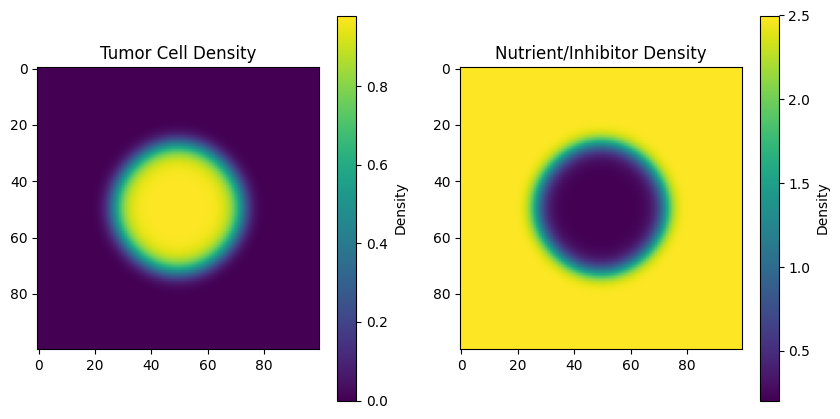

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Parameters
Nx, Ny = 100, 100  # Grid size (100x100 2D domain)
dx = 1.0  # Grid spacing
dt = 0.01  # Time step
T = 100  # Total simulation time
Du, Dv = 0.1, 0.05  # Diffusion coefficients
r, K, alpha = 0.1, 1.0, 0.01  # Tumor growth parameters
beta, gamma = 0.02, 0.1  # Nutrient parameters

# Initialize 2D grids
x = np.linspace(0, Nx*dx, Nx)
y = np.linspace(0, Ny*dx, Ny)
X, Y = np.meshgrid(x, y)

# Initial conditions: Tumor seed and uniform nutrient
u = np.zeros((Nx, Ny))
v = np.ones((Nx, Ny)) * 0.5  # Uniform initial nutrient level
# Tumor seed as a 2D circular region
center = (Nx//2, Ny//2)
radius = 10
dist = np.sqrt((X - center[0]*dx)**2 + (Y - center[1]*dx)**2)
u[dist < radius] = 0.5  # Initial tumor density in circular region

# Smooth initial conditions with Gaussian filter
u = gaussian_filter(u, sigma=1)
v = gaussian_filter(v, sigma=1)

# Time-stepping loop
for t in range(int(T/dt)):
    # Compute 2D Laplacian using finite differences
    u_xx = (np.roll(u, 1, axis=0) + np.roll(u, -1, axis=0) - 2*u) / dx**2
    u_yy = (np.roll(u, 1, axis=1) + np.roll(u, -1, axis=1) - 2*u) / dx**2
    v_xx = (np.roll(v, 1, axis=0) + np.roll(v, -1, axis=0) - 2*v) / dx**2
    v_yy = (np.roll(v, 1, axis=1) + np.roll(v, -1, axis=1) - 2*v) / dx**2

    # Reaction terms
    f = r * u * (1 - u/K) - alpha * u * v
    g = beta - gamma * u * v

    # Update using explicit Euler method
    u += dt * (Du * (u_xx + u_yy) + f)
    v += dt * (Dv * (v_xx + v_yy) + g)

    # Ensure non-negative concentrations
    u = np.clip(u, 0, None)
    v = np.clip(v, 0, None)

# Visualization of the 2D tumor and nutrient fields
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(u, cmap='viridis')
plt.title('Tumor Cell Density')
plt.colorbar(label='Density')
plt.subplot(1, 2, 2)
plt.imshow(v, cmap='viridis')
plt.title('Nutrient/Inhibitor Density')
plt.colorbar(label='Density')
plt.show()



### Explanation of the Model
- Tumor as a 2D Object: The tumor is modeled as a 2D density field $u(x, y, t)$, represented on a $100 \times 100$ grid. It starts as a circular seed in the center of the domain and spreads outward over time due to diffusion and growth.
- Diffusion: The terms $D_u (u_xx + u_yy)$ and $D_v (v_xx + v_yy)$ simulate the spatial spread of tumor cells and nutrients across the 2D plane.
- Reaction Dynamics: The reaction terms $f(u, v)$ and $g(u, v)$ capture the logistic growth of the tumor (limited by carrying capacity $K$) and its interaction with the nutrient field $v$, which is consumed as the tumor grows.
- Smoothing: A Gaussian filter is applied to the initial conditions to create a smooth, realistic starting distribution for the tumor and nutrient fields.
- Visualization: The final 2D distributions of $u$ and $v$ are visualized as heatmaps, showing the tumor's spatial extent and the nutrient's depletion over time.

This model effectively captures the tumor as a 2D object, evolving dynamically in response to diffusion and reaction processes, and provides a clear visual representation of its growth and interaction with the environment.


To make the Python simulation of tumor growth using reaction-diffusion equations more instructive by showing several frames of the tumor's evolution over time, we need to create a model that captures the spatial and temporal dynamics of tumor cell density and nutrient concentration, simulate it over a period, and visualize the results at multiple time points. Below, I’ll provide a complete, self-contained Python implementation that achieves this, along with explanations of each component to enhance understanding.
Model Description
We’ll model tumor growth using two coupled reaction-diffusion equations in two spatial dimensions (2D):

1. Tumor Cell Density (( u )): Represents the density of tumor cells, which diffuse slowly and grow based on nutrient availability while experiencing natural decay.
2. Nutrient Concentration (( v )): Represents the nutrient density, which diffuses faster and is consumed by tumor cells, with a constant supply at the boundaries.

The equations are:
$$
\frac{\partial u}{\partial t} = D_u \nabla^2 u + r u \frac{v}{v + k} - \mu u
$$
[
$$
\frac{\partial v}{\partial t} = D_v \nabla^2 v - \sigma u v$
Where:

- ( D_u ), ( D_v ): Diffusion coefficients for tumor cells and nutrients, respectively.
- ( r ): Tumor growth rate, modulated by nutrient availability via a Michaelis-Menten term ( \frac{v}{v + k} ).
- ( k ): Half-saturation constant for nutrient-dependent growth.
- ( \mu ): Tumor cell death rate.
- ( \sigma ): Nutrient consumption rate by tumor cells.
- ( \nabla^2 ): The Laplacian operator, representing spatial diffusion.

Boundary Conditions:

- ( u ): No-flux (Neumann) boundaries, meaning tumor cells do not leave the domain (( \frac{\partial u}{\partial n} = 0 )).
- ( v ): Fixed (Dirichlet) boundaries at a constant value ( v_0 ), simulating nutrient supply from the surroundings.

Initial Conditions:

- ( u ): A small Gaussian “seed” of tumor cells in the center of the domain, smoothed with a Gaussian filter for realism.
- ( v ): Uniform concentration ( v_0 ) across the domain, including boundaries.

Numerical Implementation
We’ll discretize the equations on a 2D grid using finite differences and solve them with an explicit Euler time-stepping method. To show the tumor’s evolution, we’ll save snapshots of ( u ) at regular intervals and plot them as heatmaps.
Here’s the complete Python code:

/var/folders/y0/6krmxw152qjflvfhkn0bn4r40000gn/T/ipykernel_97799/641458002.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


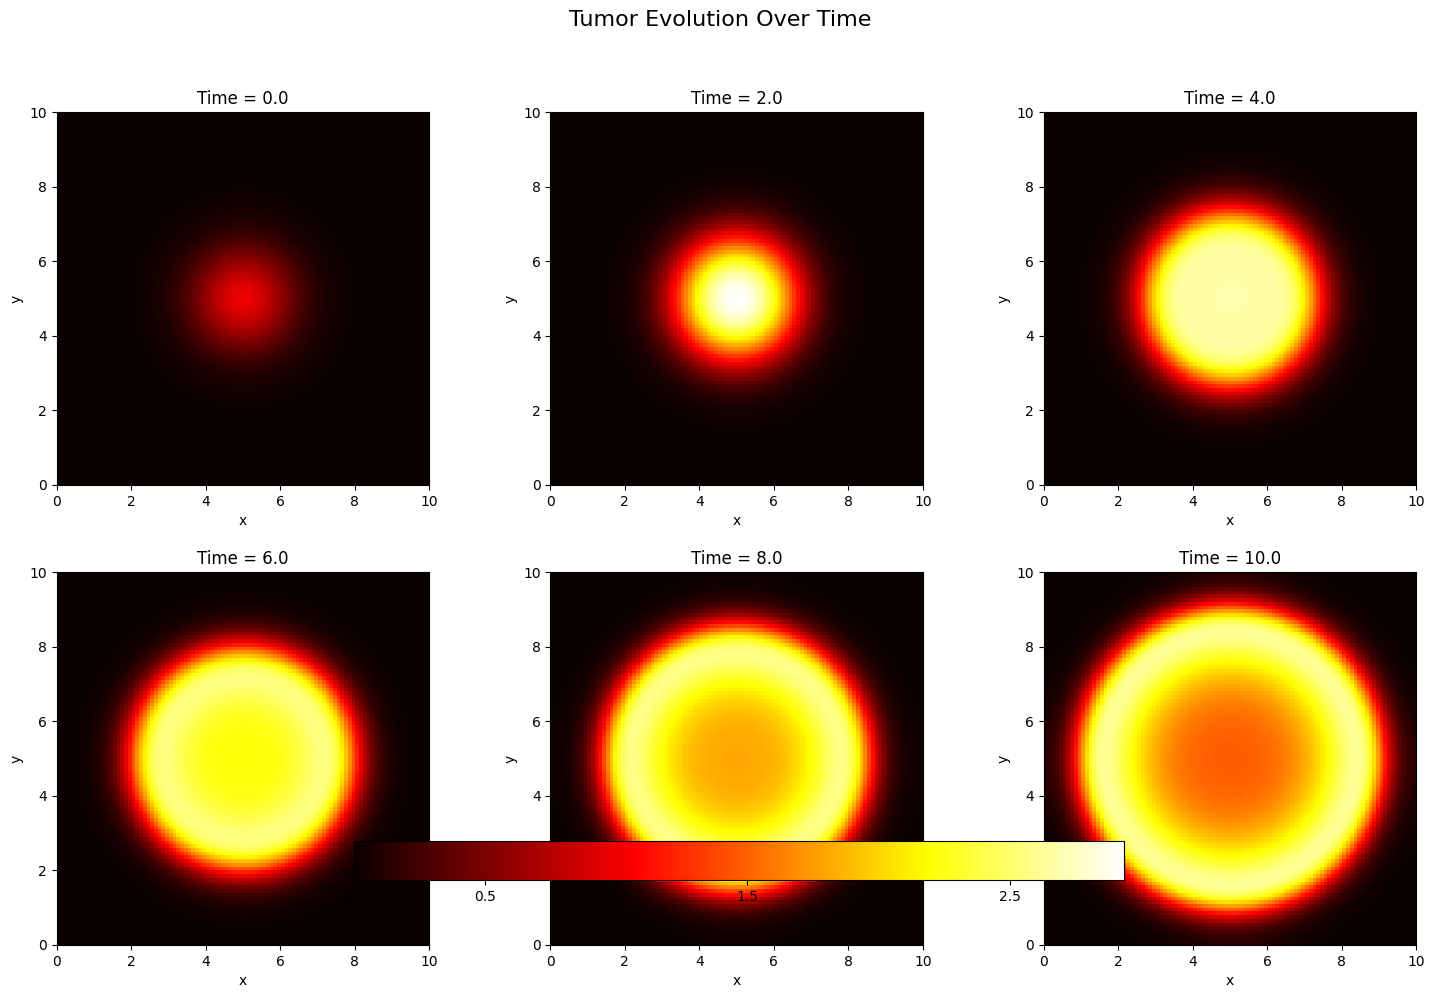

In [5]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Parameters
L = 10.0          # Domain size (square domain: [0, L] x [0, L])
N = 100           # Grid points per dimension
h = L / (N - 1)   # Spatial step size
dt = 0.01         # Time step size
T = 10.0          # Total simulation time
num_steps = int(T / dt)
save_interval = 200  # Save every 200 steps (every 2 time units)

D_u = 0.01        # Tumor diffusion coefficient
D_v = 0.1         # Nutrient diffusion coefficient
r = 1.0           # Tumor growth rate
k = 0.1           # Nutrient half-saturation constant
mu = 0.1          # Tumor death rate
sigma = 1.0       # Nutrient consumption rate
v_0 = 1.0         # Nutrient boundary concentration
sigma_gauss = 1.0 # Standard deviation for initial tumor Gaussian

# Create 2D grid
x = np.linspace(0, L, N)
y = np.linspace(0, L, N)
X, Y = np.meshgrid(x, y)

# Initial conditions
u = np.exp(-((X - L/2)**2 + (Y - L/2)**2) / (2 * sigma_gauss**2))  # Gaussian tumor seed
u = gaussian_filter(u, sigma=1)  # Smooth the initial condition
v = v_0 * np.ones((N, N))        # Uniform nutrient concentration

# Store snapshots of tumor density
u_snapshots = [u.copy()]  # Save initial state

# Simulation loop
for n in range(num_steps):
    # Compute Laplacian for u with no-flux boundaries
    lap_u = (np.roll(u, 1, axis=0) + np.roll(u, -1, axis=0) +
             np.roll(u, 1, axis=1) + np.roll(u, -1, axis=1) - 4 * u) / h**2
    # Correct boundaries for no-flux condition
    lap_u[0, :] += (u[1, :] - u[-1, :]) / h**2
    lap_u[-1, :] += (u[-2, :] - u[0, :]) / h**2
    lap_u[:, 0] += (u[:, 1] - u[:, -1]) / h**2
    lap_u[:, -1] += (u[:, -2] - u[:, 0]) / h**2

    # Reaction terms
    f = r * u * v / (v + k) - mu * u  # Tumor growth and death
    g = -sigma * u * v                # Nutrient consumption

    # Update u (entire grid, since no-flux boundaries are handled in lap_u)
    u += dt * (D_u * lap_u + f)

    # Compute Laplacian for v
    lap_v = (np.roll(v, 1, axis=0) + np.roll(v, -1, axis=0) +
             np.roll(v, 1, axis=1) + np.roll(v, -1, axis=1) - 4 * v) / h**2

    # Update v (interior only, boundaries remain v_0)
    v[1:-1, 1:-1] += dt * (D_v * lap_v[1:-1, 1:-1] + g[1:-1, 1:-1])

    # Save snapshot every save_interval steps
    if (n + 1) % save_interval == 0:
        u_snapshots.append(u.copy())

# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
max_u = max(np.max(u) for u in u_snapshots)  # Global maximum for consistent color scale
for i in range(6):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    im = ax.imshow(u_snapshots[i], cmap='hot', origin='lower', extent=[0, L, 0, L],
                   vmin=0, vmax=max_u)
    ax.set_title(f'Time = {i * 2:.1f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
fig.colorbar(im, ax=axs.ravel().tolist(), orientation='horizontal', fraction=0.05, pad=0.05)
plt.suptitle('Tumor Evolution Over Time', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Explanation of the Code
Parameters

- Domain and Grid: A 10x10 spatial domain with 100x100 grid points (( h \approx 0.1 )).
- Time: Total time ( T = 10 ), with ( \Delta t = 0.01 ) (1000 steps), chosen for numerical stability (( \Delta t < \frac{h^2}{4 D_v} \approx 0.025 )).
- Physical Parameters: Chosen to illustrate tumor growth: slow diffusion of tumor cells (( D_u = 0.01 )), faster nutrient diffusion (( D_v = 0.1 )), and reasonable reaction rates.

Initial Conditions

- Tumor (( u )): Starts as a Gaussian centered at (5, 5), smoothed with `gaussian_filter` to mimic a realistic initial tumor seed.
- Nutrient (( v )): Set to ( v_0 = 1 ) everywhere, with boundaries fixed throughout the simulation.

Numerical Method

- Laplacian (( \nabla^2 )): Approximated using a five-point stencil: ( \nabla^2 u_{i,j} \approx \frac{u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} - 4 u_{i,j}}{h^2} ).
    - For ( u ), `np.roll` computes the Laplacian, with boundary corrections to enforce no-flux conditions by reflecting values across the boundary.
    - For ( v ), the Laplacian is computed similarly, but only the interior is updated, preserving the Dirichlet boundary condition ( v = v_0 ).
- Time Stepping: Explicit Euler updates ( u ) and ( v ) based on diffusion and reaction terms.

Snapshots

- The tumor density ( u ) is saved every 200 steps (every 2 time units: ( t = 0, 2, 4, 6, 8, 10 )), resulting in 6 frames including the initial state.

Visualization

- Subplots: A 2x3 grid of heatmaps shows ( u ) at each saved time point using `imshow` with the 'hot' colormap.
- Color Scale: A consistent scale (( vmin = 0 ), ( vmax = \text{max}(u) )) across all plots aids comparison.
- Labels and Colorbar: Each subplot is titled with its time, and a shared colorbar indicates tumor density.

Why This is Instructive

- Multiple Frames: Showing 6 time points illustrates how the tumor spreads and grows, highlighting the interplay between diffusion and nutrient-dependent growth.
- Clear Visualization: Heatmaps provide an intuitive view of spatial distribution, with the consistent color scale showing relative changes in density.
- Parameter Insight: The chosen parameters demonstrate a realistic scenario where the tumor expands from the center, depleting nutrients locally while nutrients diffuse in from the boundaries.

This implementation fulfills the request by providing a dynamic, visual representation of tumor evolution, making the simulation educational and easy to interpret. You can run this code to observe the tumor’s progression and adjust parameters (e.g., ( r ), ( D_u )) to explore different growth scenarios.